# Network of Genres

Clusters similar genres together.

In [1]:
from community import best_partition, modularity
import numpy as np
import pandas as pd
import networkx as nx
import collections as clt
import matplotlib.pyplot as plt
import pickle
import itertools
from joblib import Parallel, delayed
import math

In [2]:
df = pd.read_csv('reviews_full_v7.csv')

In [3]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [4]:
G = nx.Graph()
B = nx.Graph()

In [5]:
#construction of bipartite graph
genres = set()
users = set()
posScore = 75
def isNaN(x):
    return x != x
for index,row in df.iterrows():
    if row['Score'] < posScore: #removing reviews with low score 
        continue
    if isNaN(row['Combined_Genre']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    user = row['User']
    album = row['Release'] + 'A'
    users.add(user)
    for genre in genre_list:
        genres.add(genre)
        if B.has_edge(user,genre):
            B[user][genre]['weight'] += 1
            B[user][genre]['concepts'].add((album,user))
            #B[user][genre]['albums'].add(album)
        else:
            B.add_edge(user, genre, weight = 1, concepts = {(album,user)})
            #B.add_edge(user, genre, weight = 1, albums = {album})

In [6]:
B.number_of_nodes(), B.number_of_edges()

(8344, 33217)

[131, 125, 84, 82, 82, 81, 77, 75, 72, 72, 70, 67, 66, 64, 63, 62, 62, 61, 61, 60, 58, 55, 55, 54, 54, 54, 53, 53, 51, 51]


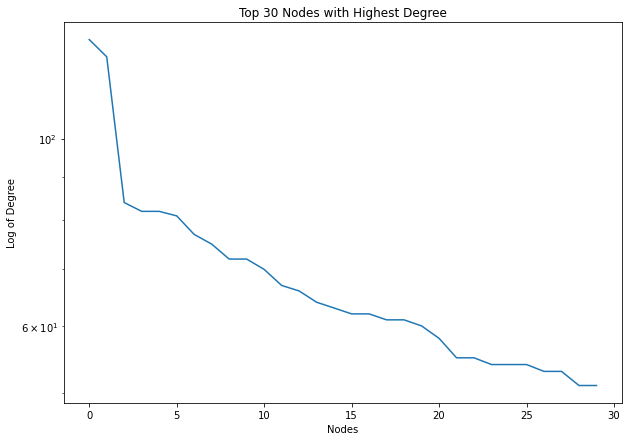

In [7]:
plt.title('Top 30 Nodes with Highest Degree')
plt.ylabel('Log of Degree')
plt.xlabel('Nodes')
tmp = sorted([B.degree[user] for user in users])[-30:]
tmp.reverse()
plt.semilogy(tmp)
print(tmp)
plt.show()

In [8]:
#removing structural holes
remove_users = set()
for user in users.copy():
    if B.degree[user] > 100:
        B.remove_node(user)
        print(user)
        remove_users.add(user)
        users.remove(user)

hells_unicorn
autothrall


In [9]:
G = nx.Graph()
for genre1 in genres:
    if genre1 not in B.nodes():
        continue
    for user in B.adj[genre1]:
        for genre2 in B.adj[user]:
            if genre2 >= genre1:
                continue
            if G.has_edge(genre1,genre2):
                G[genre1][genre2]['weight'] += 1
                G[genre1][genre2]['concepts'] = G[genre1][genre2]['concepts'].union(B[genre1][user]['concepts'].union(B[genre2][user]['concepts']))
                #G[genre1][genre2]['users'].add(user)
            else:
                G.add_edge(genre1, genre2, weight = 1, concepts = B[genre1][user]['concepts'].union(B[genre2][user]['concepts']))
                #G.add_edge(genre1, genre2, weight = 1, albums = B[genre1][user]['albums'].union(B[genre2][user]['albums']), users = {user})

In [10]:
G.number_of_nodes(), G.number_of_edges()

(289, 18130)

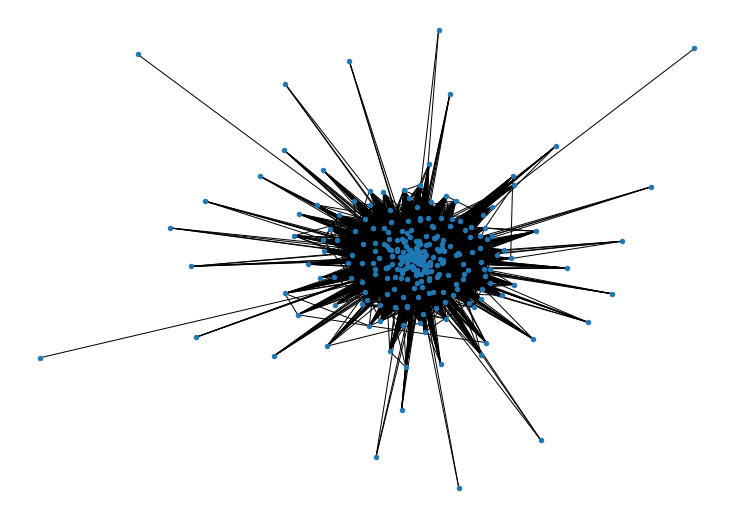

In [11]:
nx.draw(G, node_size = 20)

In [12]:
#calculating similarity between two nodes which share an edge (else default is zero).
#By using each edge, this method cuts down time complexity from O(N^2) to O(E)
def calc_sim(Graph):
    for u,v in Graph.edges():
        #similarity = 2*overlap/sum of degrees of u and v
        sum_of_degrees = Graph.degree(u,weight = 'weight')+Graph.degree(v,weight = 'weight')
        common_edges = Graph[u][v]['weight']
        Graph[u][v]['similarity'] = (2*common_edges)/sum_of_degrees #is this the best way?
        #G[u][v]['similarity'] = common_edges/(sum_of_degrees - common_edges)
    return Graph

In [13]:
def fragment(inp):
    inp = sorted(inp)
    total = sum(inp)
    return -1*sum([(x/total)*math.log(x/total) for x in inp])

In [14]:
'''tmp = sorted(list(nx.get_edge_attributes(G,'similarity').values()))
plt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])
plt.show()'''

"tmp = sorted(list(nx.get_edge_attributes(G,'similarity').values()))\nplt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])\nplt.show()"

In [15]:
genre_group = pickle.load(open('genre_group.p','rb'))
print(G.number_of_nodes())
G2 = G.copy()
for node in G2.nodes():
    #if node not in genre_group:
        #print(node)
    if node not in genre_group:
        pass
    elif  genre_group[node] == 'Non-metal' or genre_group[node] == 'Others':
        G.remove_node(node)
print(G.number_of_nodes())

289
190


In [16]:
G3 = G.copy()

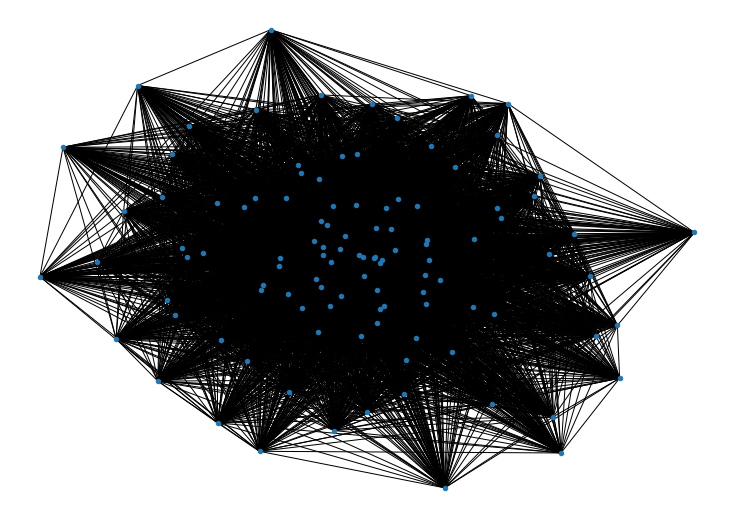

In [17]:
K = G3.copy()
K.remove_edges_from(nx.selfloop_edges(K))
K = nx.k_core(K)
sortbylen = lambda cc : len(cc)
Core = K.subgraph(sorted(list(nx.connected_components(K)), key = sortbylen)[-1])
nx.draw(Core, node_size = 20)

In [18]:
Core.number_of_nodes(),Core.number_of_edges()

(109, 5649)

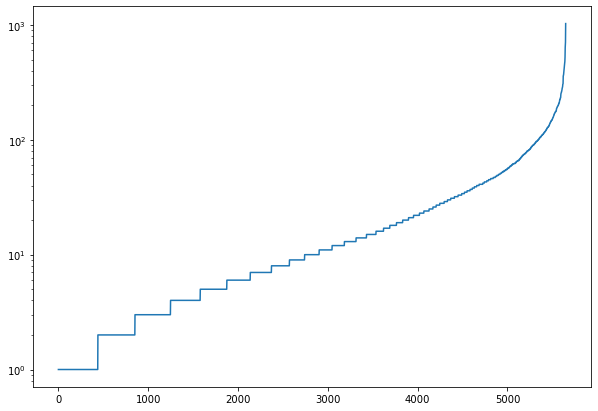

In [19]:
plt.semilogy(sorted(list(nx.get_edge_attributes(Core,'weight').values())))

In [20]:
tmp = sorted(list(nx.get_edge_attributes(Core,'weight').values()))
for i in range(len(tmp)):
    if (tmp[i] == 33):
        print(i)
        break

4450


(array([2136.,  911.,  643.,  330.,  275.,  195.,  167.,  132.,  128.,
          83.]),
 array([ 1. ,  6.5, 12. , 17.5, 23. , 28.5, 34. , 39.5, 45. , 50.5, 56. ]),
 <a list of 10 Patch objects>)

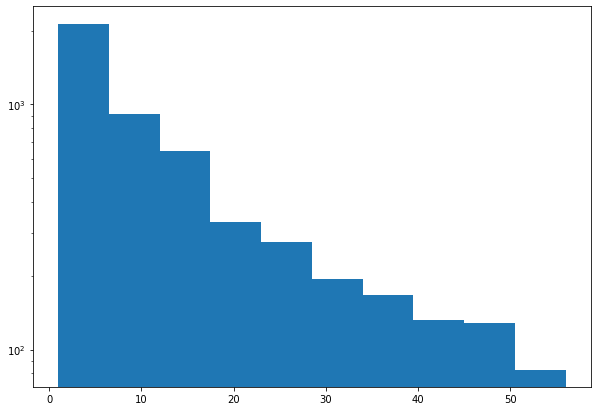

In [21]:
plt.hist(sorted(list(nx.get_edge_attributes(Core,'weight').values()))[:5000], log = True)

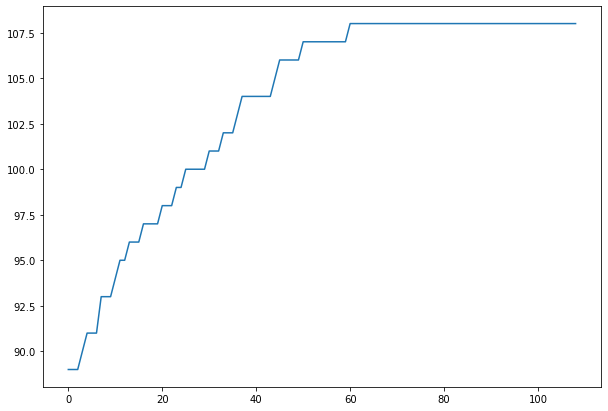

In [22]:
tmp = sorted([(v,u) for u,v in Core.degree])
#plt.xticks(rotation='vertical')
#plt.plot([x[1] for x in tmp],[x[0] for x in tmp])
plt.plot([x[0] for x in tmp])
plt.show()

In [23]:
#on hold first
'''G = G3.copy()
G2 = G.copy()
print(list(nx.isolates(G)))

for u,v in G2.edges():
    if G2[u][v]['weight'] < 5: #10 for double counting
        G.remove_edge(u,v)
        
nx.number_connected_components(G)
print(clt.Counter([len(cc) for cc in nx.connected_components(G)]))
print(list(nx.isolates(G)))
G.remove_nodes_from(list(nx.isolates(G)))
G.number_of_nodes()'''

"G = G3.copy()\nG2 = G.copy()\nprint(list(nx.isolates(G)))\n\nfor u,v in G2.edges():\n    if G2[u][v]['weight'] < 5: #10 for double counting\n        G.remove_edge(u,v)\n        \nnx.number_connected_components(G)\nprint(clt.Counter([len(cc) for cc in nx.connected_components(G)]))\nprint(list(nx.isolates(G)))\nG.remove_nodes_from(list(nx.isolates(G)))\nG.number_of_nodes()"

In [24]:
genre_group = pickle.load(open('genre_group.p','rb'))
len(genre_group)

298

In [25]:
'''tmp = [item.split(', ')[:-1] for item in open('genre_group.txt').read().split('\n\n')]
mp = {}
for genre in tmp:
    for item in genre[1:]:
        mp[item] = genre[0]
pickle.dump(mp,open('genre_group.p','wb'))
f = open('genres.txt').read().split('\n')[:-1]
for item in f:
    if item not in genre_group:
        print(item)'''

"tmp = [item.split(', ')[:-1] for item in open('genre_group.txt').read().split('\n\n')]\nmp = {}\nfor genre in tmp:\n    for item in genre[1:]:\n        mp[item] = genre[0]\npickle.dump(mp,open('genre_group.p','wb'))\nf = open('genres.txt').read().split('\n')[:-1]\nfor item in f:\n    if item not in genre_group:\n        print(item)"

In [26]:
def freq_network_parr(Graph, n_iter, n_jobs, width = 'weight', res = 1):#Graph is new frequency network
    partitions = Parallel(n_jobs=n_jobs)(delayed(best_partition)(Graph, randomize = True, weight = width, resolution = res) for i in range(n_iter))
    #partitions = [best_partition(Graph, randomize = True, weight = 'weight') for i in range(n_iter)]
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]))
    print(nx.number_connected_components(Graph), N, len(Graph.edges()))
    prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    G = nx.Graph()
    for partition in partitions:# for n_iter number of iterations
        #partition = best_partition(Graph, randomize = True, weight = 'weight')
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if G.has_edge(u,v):
                    G[u][v][width] += 1
                else:
                    G.add_edge(u,v)
                    G[u][v][width] = 1
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(G)]))
    print(nx.number_connected_components(G), N, G.number_of_edges())
    return G

def no_crossedges(Graph):
    return sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]) == Graph.number_of_edges()

In [27]:
def plotThreshold(Graph, thres):
    J = Graph.copy()
    for u,v in Graph.edges():
        if Graph[u][v]['weight'] < thres: #10 for double counting
            J.remove_edge(u,v)
    J.remove_nodes_from(list(nx.isolates(J)))
    L = J.copy()
    while not no_crossedges(L):
        L = freq_network_parr(L, 10, 4)
    print(thres,nx.number_connected_components(J),nx.number_connected_components(L),J.number_of_nodes())
    comps = nx.connected_components(L)
    part = {}
    for i,comp in enumerate(comps):
        for x in comp:
            part[x] = i
    #return modularity(part,J)
    inter = 0
    intra = 0
    for u,v in J.edges():
        if part[u] == part[v]:
            intra += 1
        else:
            inter += 1
            
    return inter/intra

'''plt.title('Modularity against Weight Threshold')
plt.ylabel('Modularity')
mods = [plotThreshold(Core.copy(), i) for i in range(15,25)]
plt.plot(mods)
plt.show()'''

"plt.title('Modularity against Weight Threshold')\nplt.ylabel('Modularity')\nmods = [plotThreshold(Core.copy(), i) for i in range(15,25)]\nplt.plot(mods)\nplt.show()"

In [28]:
#print(list(enumerate(mods)))

In [29]:
'''#Use modularity and Inter-Intra edges to determine weight threshold
#Use value of 20 (remove any edge below 20)
CoreNew = nx.Graph(Core)
edgeThres = 20
for u,v in Core.edges():
    if Core[u][v]['weight'] < edgeThres:
        CoreNew.remove_edge(u,v)
print(list(nx.isolates(CoreNew)))
CoreNew.remove_nodes_from(list(nx.isolates(CoreNew)))
CoreNew.number_of_nodes(),CoreNew.number_of_edges()
CoreNew = Core
'''

"#Use modularity and Inter-Intra edges to determine weight threshold\n#Use value of 20 (remove any edge below 20)\nCoreNew = nx.Graph(Core)\nedgeThres = 20\nfor u,v in Core.edges():\n    if Core[u][v]['weight'] < edgeThres:\n        CoreNew.remove_edge(u,v)\nprint(list(nx.isolates(CoreNew)))\nCoreNew.remove_nodes_from(list(nx.isolates(CoreNew)))\nCoreNew.number_of_nodes(),CoreNew.number_of_edges()\nCoreNew = Core\n"

In [30]:
'''tmp = sorted([(v,u) for u,v in G3.degree])[-30:]
plt.xticks(rotation='vertical')
plt.plot([x[1] for x in tmp],[x[0] for x in tmp])
plt.ylabel('Degree')
plt.title('Degree of Top 30 Genres in Network of Genres')
plt.show()
remove_genres = [u for v,u in tmp[-16:] if len(u.split(' ')) <= 2]
print(remove_genres)
#G.remove_nodes_from(remove_genres)'''

"tmp = sorted([(v,u) for u,v in G3.degree])[-30:]\nplt.xticks(rotation='vertical')\nplt.plot([x[1] for x in tmp],[x[0] for x in tmp])\nplt.ylabel('Degree')\nplt.title('Degree of Top 30 Genres in Network of Genres')\nplt.show()\nremove_genres = [u for v,u in tmp[-16:] if len(u.split(' ')) <= 2]\nprint(remove_genres)\n#G.remove_nodes_from(remove_genres)"

In [31]:
#H = G.copy()
H = Core.copy()
#0.9 is good
#H = freq_network_parr(H, 100, 4, res = 0.8)
while not no_crossedges(H):
    H = freq_network_parr(H, 100, 4)

1 5886 5649
1 5886 4224
1 5886 4224
3 2372 2372


In [32]:
partitions = [cc for cc in nx.connected_components(H)]

In [33]:
def getScore(Graph):#using original graph
    comps = list(nx.connected_components(Graph))
    subgraphs = [Core.subgraph(comp) for comp in comps]
    ave_weight = [sum([Core[u][v]['weight']/sub.number_of_edges() for u,v in sub.edges()]) for sub in subgraphs]
    ave_cluster_weight = [sum([Core[u][v]['weight']/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for u,v in sub.edges()]) for sub in subgraphs]
    density = [sub.number_of_edges()/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for sub in subgraphs]
    std_dev = [np.std([Core[u][v]['weight'] for u,v in sub.edges()]) for sub in subgraphs]
    #ave_coeff = [nx.average_clustering(Core, nodes = sub.nodes(), weight = 'weight') for sub in subgraphs]
    ave_coeff = [nx.average_clustering(sub, weight = 'weight') for sub in subgraphs]
    #ave_weight1 = [np.mean([G[u][v]['weight'] for u,v in sub.edges()]) for sub in subgraphs]
    return ave_weight, ave_cluster_weight, density, std_dev, ave_coeff

In [34]:
[len(cc) for cc in partitions]

[12, 47, 50]

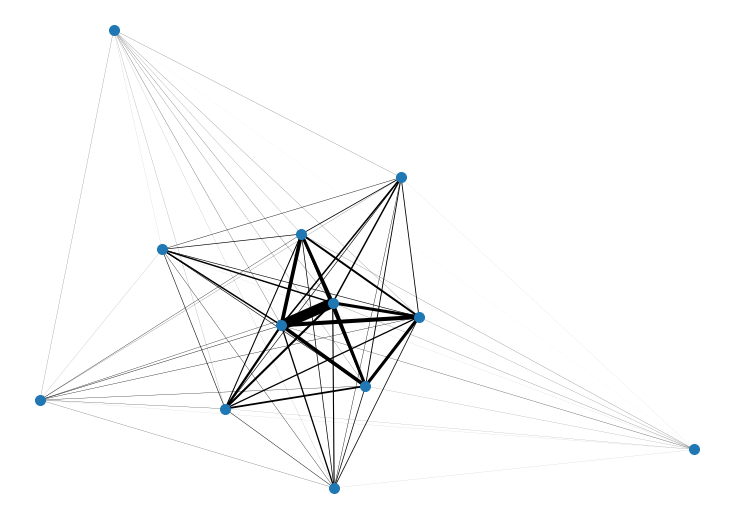

In [35]:
cluster = Core.subgraph(list(nx.connected_components(H))[0])
nx.draw(cluster, node_size = 100,  font_size = 12, edge_color = 'black', width = np.array([Core[u][v]['weight'] for u,v in cluster.edges()])*0.01)
plt.show()

In [36]:
def genData(Graph, ind):
    ret = pd.DataFrame()
    ret['Genres'] = list(nx.connected_components(Graph))
    ret['Sizes'] = [len(cc) for cc in nx.connected_components(Graph)]
    ret['Average_Weight'], ret['Average_Weight_by_Nodes'], ret['Cluster_Density'], ret['Std_Dev'], ret['Average_Clustering_Coefficient'] = getScore(Graph)
    ret.to_csv('round'+str(ind)+'_genre.csv', index = False)
    return ret
data = genData(H,1)
data

,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{industrial grindcore, black metal, death meta...",12,103.515152,103.515152,1.000000,153.860547,0.073517
1,"{groove thrash metal, symphonic gothic metal, ...",47,26.077661,25.160962,0.964847,55.676152,0.024691
2,"{atmospheric death metal, atmospheric doom met...",50,21.265494,20.727347,0.974694,29.108485,0.063246


In [37]:
clusters = []
inp = int(input('Enter Cluster ID to Keep: '))
clusters.append(G.subgraph(list(nx.connected_components(H))[inp]))

Enter Cluster ID to Keep:  0


In [38]:
from IPython.display import display, HTML
def breakDown(inds):
    for ind in inds:
        G1 = Core.subgraph(list(nx.connected_components(H))[ind])
        while not no_crossedges(G1):
            G1 = freq_network_parr(G1, 100, 4)
        print('End Clustering: ',ind)
        display(genData(G1,'2-'+ str(ind)))
        for comp in nx.connected_components(G1):
            clusters.append(Core.subgraph(comp))

In [39]:
inp = 0
tmp = []
inp = input('Enter Cluster IDs for Breakdown: ')
breakDown([int(x) for x in inp.split()])

Enter Cluster IDs for Breakdown:  1 2


1 1081 1043
1 1081 872
1 1081 872
2 535 535
End Clustering:  1


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{symphonic gothic metal, melodic power metal, ...",21,60.908213,60.038095,0.985714,106.320345,0.058792
1,"{groove thrash metal, progressive thrash metal...",26,10.479100,10.027692,0.956923,12.335296,0.122933


1 1225 1194
1 1225 947
1 1225 947
4 385 385
End Clustering:  2


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{post-metal, depressive black metal, atmospher...",8,38.714286,38.714286,1.000000,30.775520,0.234558
1,"{atmospheric doom metal, atmospheric gothic me...",6,24.000000,24.000000,1.000000,30.086542,0.168902
2,"{atmospheric death metal, symphonic black meta...",24,19.219331,18.731884,0.974638,24.053848,0.099907
3,"{psychedelic stoner metal, doom metal, psyched...",12,31.333333,31.333333,1.000000,51.249932,0.084124


103.51515151515152


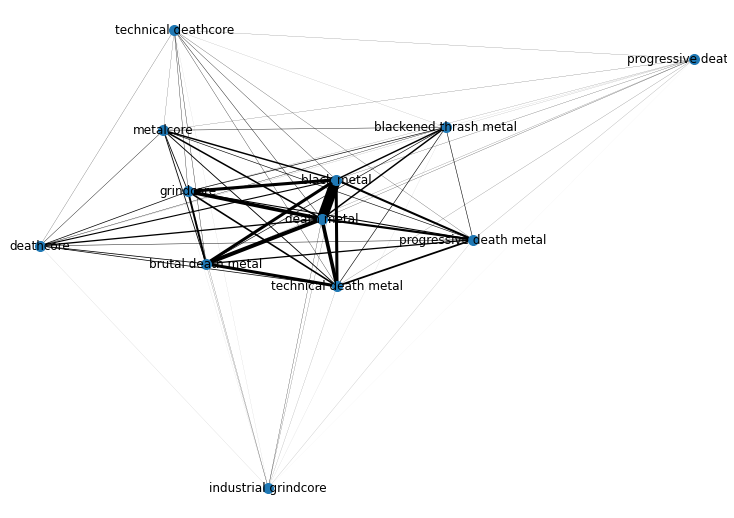

60.908212560386474


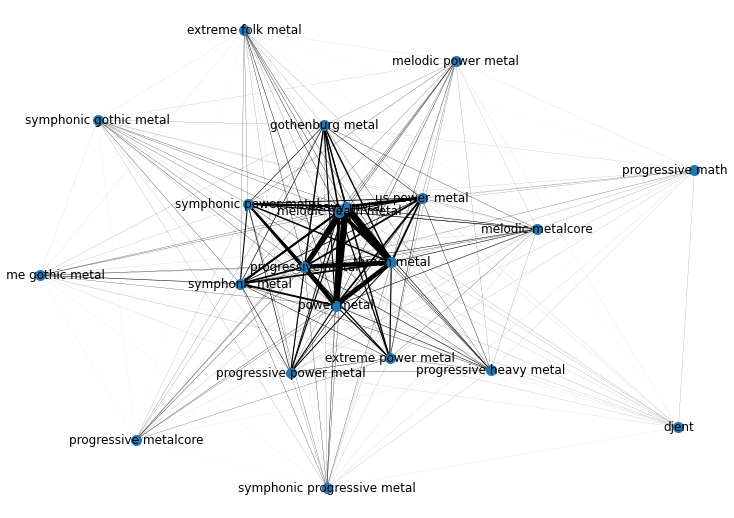

10.479099678456592


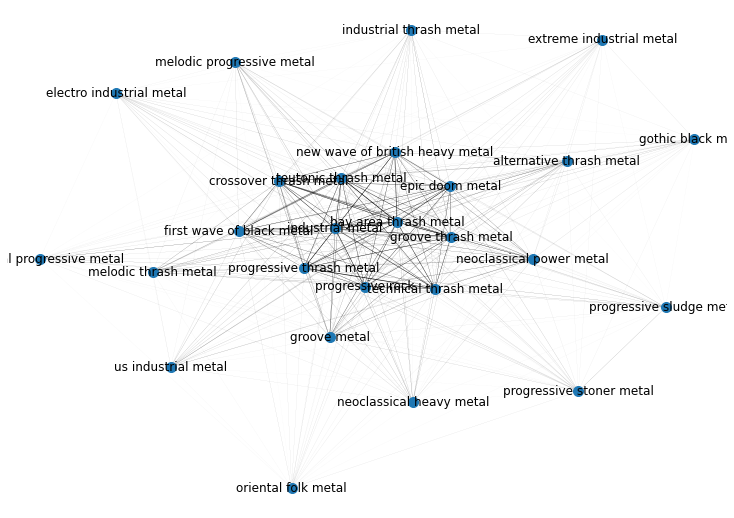

38.714285714285715


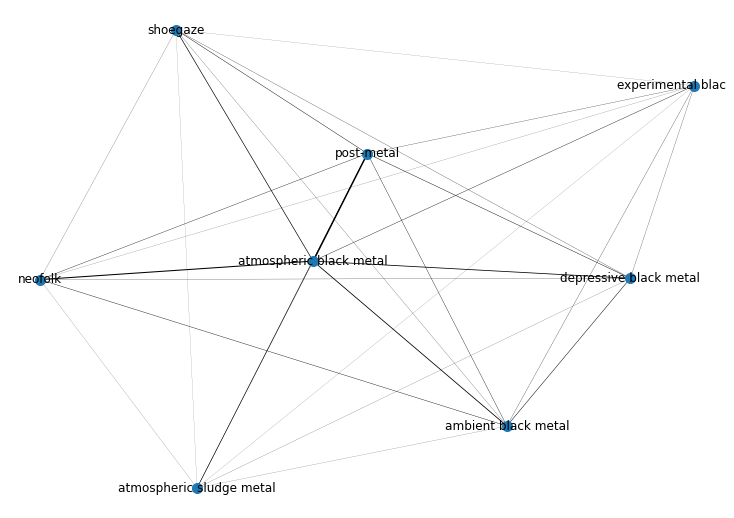

24.0


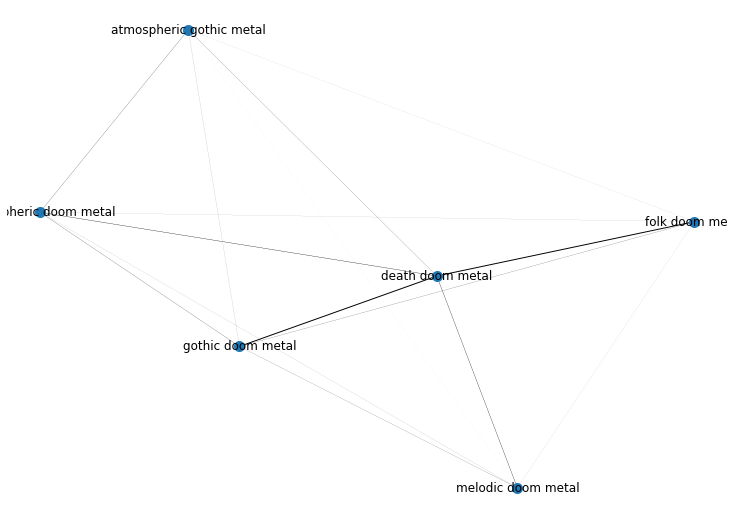

19.219330855018587


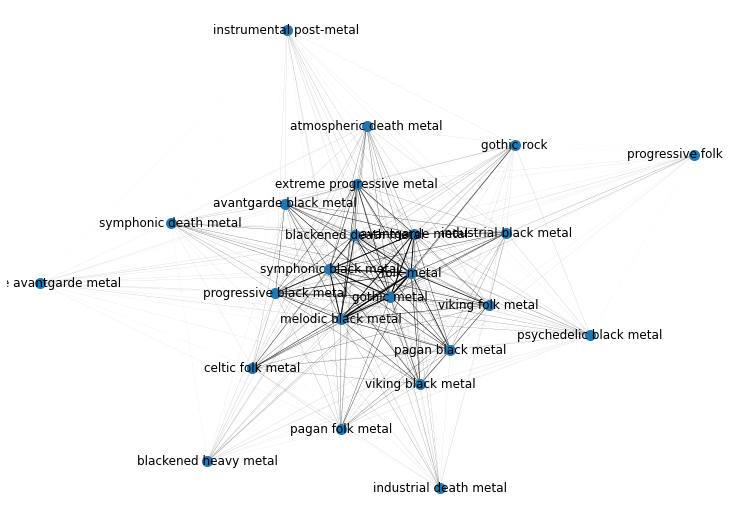

31.333333333333332


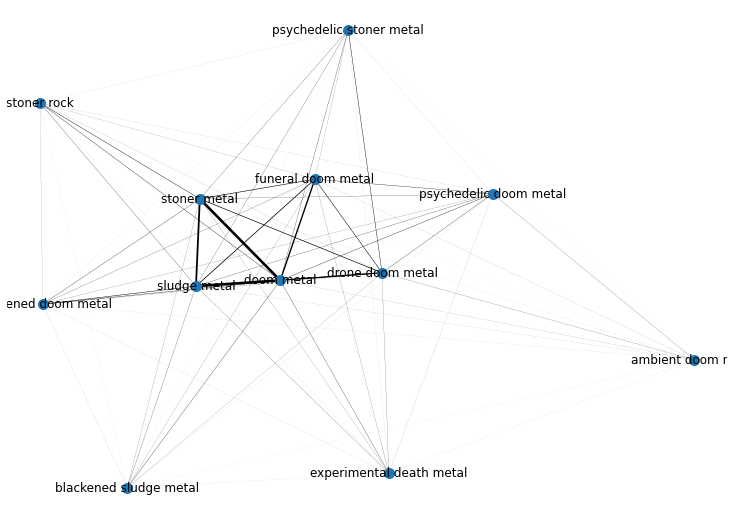

In [40]:
for cluster in clusters:
    nx.draw(cluster, node_size = 100, with_labels = True, font_size = 12, edge_color = 'black', width = np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])*0.01)
    print(np.mean(np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])))
    plt.show()

In [41]:
G['extreme folk metal']['extreme gothic metal']

{'weight': 4,
 'concepts': {('Cruelty_and_the_BeastA', 'doomknocker'),
  ('Cruelty_and_the_BeastA', 'vicioustroll'),
  ('Damnation_and_a_DayA', 'langstondrive'),
  ('Darkly%2C_Darkly%2C_Venus_AversaA', 'burnoutfool'),
  ('Darkly%2C_Darkly%2C_Venus_AversaA', 'doomknocker'),
  ('From_AfarA', 'doomknocker'),
  ('From_the_Cradle_to_EnslaveA', 'langstondrive'),
  ('Godspeed_on_the_Devil%27s_ThunderA', 'doomknocker'),
  ('Hammer_of_the_WitchesA', 'doomknocker'),
  ('Jaktens_tidA', 'langstondrive'),
  ('MidianA', 'doomknocker'),
  ('Midnattens_widunderA', 'langstondrive'),
  ('Midnight_in_the_LabyrinthA', 'doomknocker'),
  ('NifelvindA', 'burnoutfool'),
  ('NifelvindA', 'doomknocker'),
  ('One_Man_ArmyA', 'doomknocker'),
  ('Total_Fucking_DarknessA', 'doomknocker'),
  ('TrollhammarenA', 'vicioustroll')}}

In [42]:
'''x = 'folk doom metal'
w = sorted([(Core[x][u]['weight'],u) for u in list(Core[x])])
w'''

"x = 'folk doom metal'\nw = sorted([(Core[x][u]['weight'],u) for u in list(Core[x])])\nw"

In [43]:
'''cluster = clusters[3]
nx.draw(cluster, node_size = 100, with_labels = True, font_size = 12, edge_color = 'black', width = np.array([Core[u][v]['weight'] for u,v in cluster.edges()])*0.01)
plt.show()'''

"cluster = clusters[3]\nnx.draw(cluster, node_size = 100, with_labels = True, font_size = 12, edge_color = 'black', width = np.array([Core[u][v]['weight'] for u,v in cluster.edges()])*0.01)\nplt.show()"

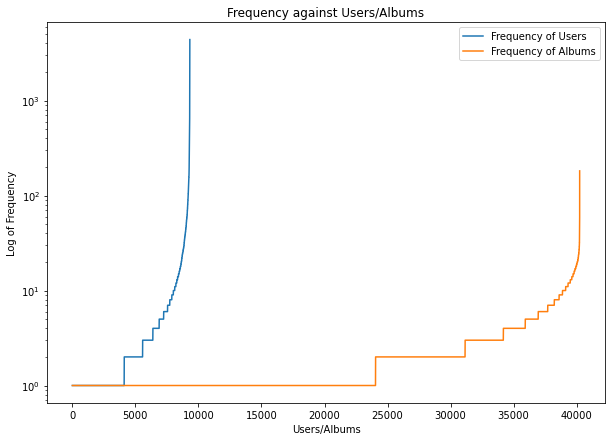

In [44]:
user_mp = clt.Counter(df['User'])
album_mp = clt.Counter(df['Release'])
#print(user_mp)
#print(album_mp)
plt.title('Frequency against Users/Albums')
plt.ylabel('Log of Frequency')
plt.xlabel('Users/Albums')
plt.semilogy(sorted(user_mp.values()), label = 'Frequency of Users')
plt.semilogy(sorted(album_mp.values()), label = 'Frequency of Albums')
plt.legend()
plt.show()

In [45]:
from concepts import Context

In [46]:
def genLattice(ind):
    cluster = clusters[ind]
    user_list = set()
    album_list = set()
    cxt = set()
    for u,v in cluster.edges():
        conc = cluster[u][v]['concepts']
        for album, user in conc:
            if user_mp[user] < 3 or album_mp[album[:-1]] < 10 or user in remove_users:
                continue
            user_list.add(user)
            album_list.add(album)
            cxt.add((album,user))
    user_list = list(user_list)
    album_list = list(album_list)
    print(ind, cluster.number_of_nodes(), len(user_list), len(album_list), len(cxt))
    context_df = pd.DataFrame()
    for user in user_list:
        arr = []
        for album in album_list:
            if (album,user) in cxt:
                arr.append('X')
            else:
                arr.append('')
        context_df[user] = arr
    context_df.index = album_list
    context_df.to_csv('fca.csv')
    c = Context.fromfile('fca.csv', frmat = 'csv')
    l = c.lattice
    return l

In [47]:
def writeConcepts(ind):
    l = genLattice(ind)
    conc = sorted([(len(x),len(y)) for x,y in l], reverse = True)
    f = open('concepts_cluster'+str(ind)+'.txt','w')
    for x in conc:
        f.write(str(x))
        f.write('\n')
    f.close()

In [48]:
for ind in range(len(clusters)):
    writeConcepts(ind)

0 12 1021 398 3244
1 21 1133 581 4762
2 26 392 163 1246
3 8 195 59 378
4 6 147 24 217
5 24 428 140 988
6 12 227 58 377


In [49]:
'''l = genLattice(0)
x,y = l[1500]
x,y,len(l)'''

'l = genLattice(0)\nx,y = l[1500]\nx,y,len(l)'

In [50]:
nx.write_gpickle(Core,'network_genres.p')